## Предсказания для золотодобычи

<a href='#section1'>1. Подготовка данных</a>

<a href='#section2'>2. Анализ данных</a>

<a href='#section3'>3. Модель</a>

<a href='#section4'>Вывод</a>

<a id='section1'></a>
### 1. Подготовка данных

Проверим, что  рассчёт эффективности обогащения правильный.

In [1]:
import pandas as pd
import warnings
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('/datasets/gold_recovery_train.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
full = pd.read_csv('/datasets/gold_recovery_full.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

Обучающая выборка содержат почти 17 тыся строк, тестовая - почти 6. В данных много пропусков и количество столбцов не совпадает. В тестовой выборке отсутствуют целевые значения.

In [4]:
train_mae = train.dropna(subset=['rougher.output.recovery'])
c = train_mae['rougher.output.concentrate_au']
f = train_mae['rougher.input.feed_au']
t = train_mae['rougher.output.tail_au']    
train_mae['recovery'] = ((c * (f - t))) / (f * (c - t)) * 100
mae = mean_absolute_error(train_mae['rougher.output.recovery'], train_mae['recovery'])
print('MAE между расчётами и значением признака', mae)

MAE между расчётами и значением признака 9.444891926100695e-15


Эффективность обогащения рассчитана правильно, т.к. ошибка очень маленькая.

In [5]:
target_cols = ['rougher.output.recovery', 'final.output.recovery']
test[target_cols[0]] = full[target_cols[0]]
test[target_cols[1]] = full[target_cols[1]]
delete_cols = []
cols = []
arr1 = train.columns.tolist()
arr2 = test.columns.tolist()
for col in arr1:
    if col not in arr2:
        delete_cols.append(col)
    else:
        cols.append(col)
        
train = train.dropna(subset=cols)
test = test.dropna()

Целевые значения в тестовой выборке заполняем из полной выборки по совпадению даты. Удалим столбцы, которых нет в тестовой выборке из тренировочной(чуть ниже, т.к. некоторые понадобятся для расчётов). Недостающие столбцы содержат данные, которые будут известны только в конце технологического процесса. Также удаляем пропуски в обеих выборках.

<a id='section2'></a>
### 2. Анализ данных

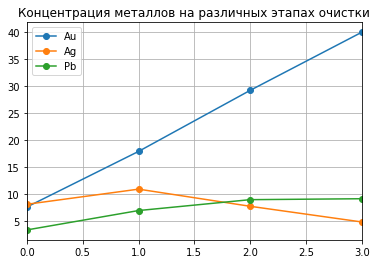

In [6]:
au = [full['rougher.input.feed_au'].mean(), full['rougher.output.concentrate_au'].mean(),
      full['primary_cleaner.output.concentrate_au'].mean(), full['final.output.concentrate_au'].mean()]

ag = [full['rougher.input.feed_ag'].mean(), full['rougher.output.concentrate_ag'].mean(),
      full['primary_cleaner.output.concentrate_ag'].mean(), full['final.output.concentrate_ag'].mean()]

pb = [full['rougher.input.feed_pb'].mean(), full['rougher.output.concentrate_pb'].mean(),
      full['primary_cleaner.output.concentrate_pb'].mean(), full['final.output.concentrate_pb'].mean()]

pd.DataFrame({'Au': au, 'Ag': ag, 'Pb': pb}).plot(style = 'o-', grid = True)
plt.title('Концентрация металлов на различных этапах очистки')
plt.show()

Концентрация золота равномерно повышается на различных этапах очистки. Концентрация свинца также постепенно повышается, в конце процесса его концентрация в четыре раза меньше золота. Серебра вначале столько же сколько и золота, а к концу в восемь раз меньше. 



Средние размеры гранул в выборках:
Обучающая -  58
Тестовая -  57


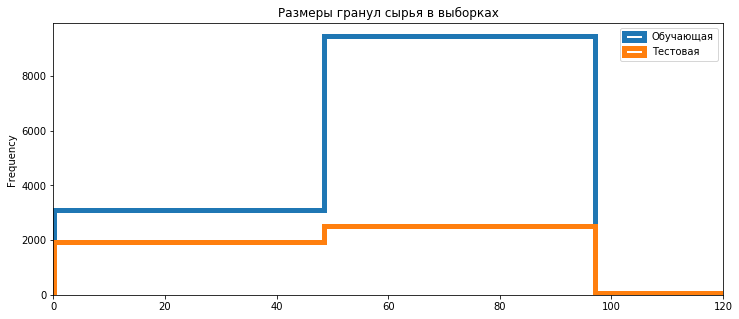

In [7]:
train_feed_size = train['rougher.input.feed_size']
test_feed_size = test['rougher.input.feed_size']
print('Средние размеры гранул в выборках:')
print('Обучающая - ', round(train_feed_size.mean()))
print('Тестовая - ', round(test_feed_size.mean()))

pd.DataFrame({'Обучающая': train_feed_size, 'Тестовая': test_feed_size}).plot(
    kind='hist', histtype='step', xlim=(0,120), linewidth='5', figsize = (12,5))
plt.title('Размеры гранул сырья в выборках')
plt.show()

(1, 180)

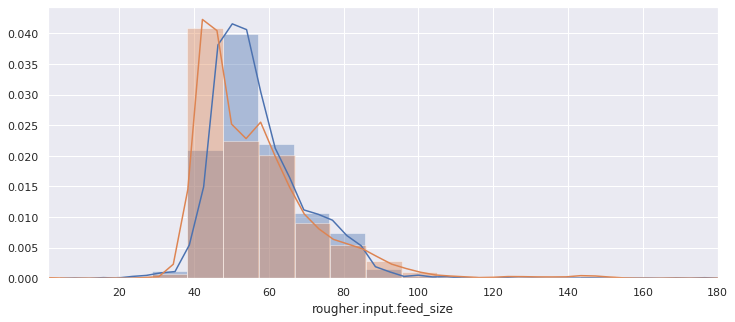

In [28]:
fig, ax = plt.subplots()
#sns.set_style('darkgrid')
#sns.set(rc={'figure.figsize':(12,5)})
sns.distplot(train_feed_size)
sns.distplot(test_feed_size)
ax.set_xlim(1,180)


Распределения размеров гранул сырья на обучающей и тестовой выборках примерно одинаковые, они имеют совпадающую форму графиков, отличаются масштабом из-за разного количества строк в данных. В тестовой выборке размеры гранул распределены более равномерно, а в обучающей больше крупных гранул.

Средние размеры гранул почти одинаковые.

<div class="alert alert-info" style="color:#000000">Добавила график, только не нашла параметр, чтобы ограничить по оси x.</div>

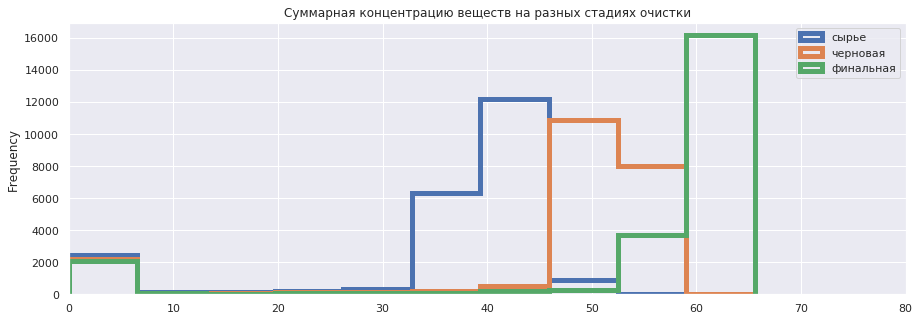

In [9]:
concentrate1 = (full['rougher.output.concentrate_au'] + 
                                full['rougher.output.concentrate_ag'] + full['rougher.output.concentrate_pb'] )

concentrate2 = (full['primary_cleaner.output.concentrate_au'] + 
                    full['primary_cleaner.output.concentrate_ag'] + full['primary_cleaner.output.concentrate_pb'])

concentrate3 = (full['final.output.concentrate_au'] + 
                                    full['final.output.concentrate_ag'] + full['final.output.concentrate_pb'])

pd.DataFrame({'сырье': concentrate1, 'черновая': concentrate2, 'финальная': concentrate3}).plot(
    kind='hist', histtype='step', linewidth='5', xlim=(0,80), figsize = (15,5))
plt.title('Суммарная концентрацию веществ на разных стадиях очистки')
plt.show()

In [10]:
train = train[((train['rougher.output.concentrate_au'] + train['rougher.output.concentrate_ag']
               + train['rougher.output.concentrate_pb'] ) != 0) &
((train['primary_cleaner.output.concentrate_au'] + train['primary_cleaner.output.concentrate_ag'] +
  train['primary_cleaner.output.concentrate_pb']) != 0) & ((train['final.output.concentrate_au'] + 
            train['final.output.concentrate_ag'] + train['final.output.concentrate_pb']) != 0)]
train = train.drop(delete_cols, axis=1)
train = train.dropna()

Исследование суммарной концентрации всех веществ на разных стадиях в полной выборке показало, что есть 0. Это аномальные значения, удалим их из обучающей выборки. В тестовой выборке таких столбцов нет.


<a id='section3'></a>
### 3. Модель
Функцию для вычисления итоговой sMAPE.

Обучим разные модели и оценим их качество кросс-валидацией.

In [11]:
# функции для вычисления sMAPE.
def smape(predictions, target):
    target = target.tolist()
    count = len(predictions)
    result = 0
    for i in range(0,count):
        result += abs(target[i] - predictions[i]) * 100 / ((abs(target[i]) + abs(predictions[i])) / 2)
        
    return result / count

def smape_all(rougher, final):       
    return 0.25 * rougher + 0.75 * final

In [12]:
train = train.drop(['date'], axis=1)
rougher = train[target_cols[0]]
final = train[target_cols[1]]
train = train.drop(target_cols, axis=1)

test = test.drop(['date'], axis=1)
rougher_test = test[target_cols[0]]
final_test = test[target_cols[1]]
test = test.drop(target_cols, axis=1)

scaler = StandardScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Размеры полученных наборов:')
print('обучающий - ', train.shape[0])
print('тестовый - ', test.shape[0])

Размеры полученных наборов:
обучающий -  12386
тестовый -  4554


In [13]:
rfc = RandomForestRegressor()
parametrs = { 'n_estimators': range (10, 80, 20), 'max_depth': range (1,10)}
grid = GridSearchCV(rfc, parametrs)
grid.fit(train, rougher)
print('Подобранные гиперпараметры для модели случайного леса')
grid.best_params_

Подобранные гиперпараметры для модели случайного леса


{'max_depth': 2, 'n_estimators': 10}

In [21]:
model = RandomForestRegressor(n_estimators = 10, max_depth = 2, random_state=12345)
model.fit(train, rougher)
predictions_rouger = model.predict(test)
model.fit(train, final)
predictions_final = model.predict(test)
smape_rouger = smape(predictions_rouger, rougher_test)
smap_final = smape(predictions_final, final_test)
print('Итоговая sMAPE', smape_all(smape_rouger, smap_final))

Итоговая sMAPE 13.005989525394178


In [15]:
svr = SVR(kernel='rbf')
parameters = {'gamma': [0.01, 0.1, 1, 10], 'C': [0.01, 0.1, 1, 10]}

grid = GridSearchCV(estimator=svr, param_grid = parameters, cv=3)
grid.fit(train, rougher)
print('Подобранные гиперпараметры для модели svr')
grid.best_params_

Подобранные гиперпараметры для модели svr


{'C': 10, 'gamma': 0.01}

In [20]:
model = SVR(kernel='rbf', C = 0.1, gamma = 0.1)
model.fit(train, rougher)
predictions_rouger = model.predict(test)
model.fit(train, final)
predictions_final = model.predict(test)
smape_rouger = smape(predictions_rouger, rougher_test)
smap_final = smape(predictions_final, final_test)
print('Итоговая sMAPE', smape_all(smape_rouger, smap_final))

Итоговая sMAPE 11.846885081821995


In [17]:
dummy_clf = DummyRegressor(strategy="median")
dummy_clf.fit(train, rougher)
dummy_rougher = dummy_clf.predict(test)
dummy_clf.fit(train, final)
dummy_final = dummy_clf.predict(test)
smape_rouger = smape(dummy_rougher, rougher_test)
smap_final = smape(dummy_final, final_test)
print('Итоговая sMAPE', smape_all(smape_rouger, smap_final))

Итоговая sMAPE 11.862462799517512


In [18]:
count = len(predictions_final)
a = np.array([final.median()])
median_final = np.repeat(a, count)
b = np.array([rougher.median()])
median_rougher = np.repeat(b, count)
smape_rouger = smape(median_rougher, rougher_test)
smap_final = smape(median_final, final_test)
print('Итоговая sMAPE', smape_all(smape_rouger, smap_final))

Итоговая sMAPE 11.862462799517512


<div class="alert alert-info" style="color:#000000">Добавила проверку модели - результат такой же как у лучшей модели.</div>
Исследовали модели случайного леса и векторную регрессию SVR. SVR показала результат лучше, но незначительно.
<a id='section4'></a>
# Вывод
В процессе работы мы предобработали данные, посчитали эффективность обогащения - она правильная.

Исследовали, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Количество золота увеличивается к концу, что соответвует золотодобыче.

Посчтитали sMAPE - значение получилось 11 - 14 для разных моделей.